In [1]:
###############################################################################
# Calculating forces on hydrodynamically and acoustically interacting spheres
# in the Rayleigh limit
# Methods based on Multibody Dynamics in Acoustophoresis (Baasch et al.)
import numpy as np
import pylab as plt
%matplotlib inline 
from matplotlib import animation, rc
from IPython.display import HTML
from time import time
import noise
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator
from scipy.spatial import ConvexHull
import os
from string import ascii_lowercase
## Fix:
# interparticle distances aren't taking periodic BCs into account (should this even use periodic BCs?)
# Periodic BCs disabled for now, search for % characters to check
# find a reasonable unit system
# check counting for pairwise interactions, loops that explicitly avoid double-counting need to 
#    also make sure that both reciprocal forces are calculated

## Figure Saving
def savefig(fig, filename):
    cmd = 'convert {} -trim {}'.format(filename, filename)
    fig.savefig(filename, bbox_inches='tight', dpi=300)
    os.system(cmd)
    
#plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{tgheros}',
                                       r'\usepackage{sansmath}',
                                       r'\sansmath',
                                       r'\usepackage{siunitx}',
                                       r'\sisetup{detect-all}']
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 36
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size':36})  

# For using line_profiler in Jupyter
%load_ext line_profiler

Run time 118.1 s
Run time 120.5 s
Run time 123.1 s
Run time 124.0 s
Run time 125.5 s
Run time 122.7 s
Run time 121.7 s
Run time 117.3 s
Anim time 24.87571668624878


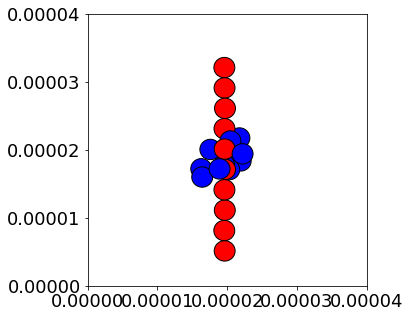

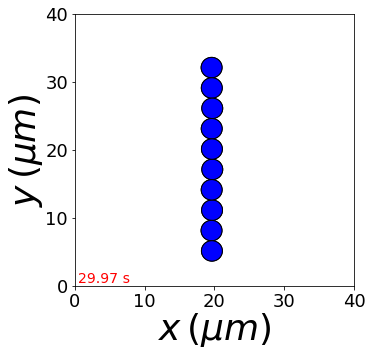

In [168]:
# Calculate physical quantities for the system and non-dimensionalize appropriately
# First calculate everything in SI units:
density_medium = 1000
soundspeed_medium =1480
density_particle = 1180
soundspeed_particle = 1480*1.2 # not known

compress_medium = 1/(density_medium*soundspeed_medium**2)
compress_particle = 1/(density_particle*soundspeed_particle**2)

compress_ratio = compress_particle/compress_medium
density_ratio = density_particle/density_medium

f0 = 1 - compress_ratio
f1 = 2*(density_ratio-1)/(2*density_ratio+1)
f0s = f0
f0p = f0
f1s = f1
f1p = f1 # all particles identical
contrast_factor = f0 + (3/2)*f1 # check this

radius = 1.5*10**(-6)
radius_unscaled = 1.5*10**(-6)
frequency = 2*10**6
wavelength = soundspeed_medium/frequency
wavenumber = 2*np.pi/wavelength

dynamic_viscosity = 8.9 *10**(-4) # Pa*s
viscosity = dynamic_viscosity

acoustic_energy_density = 20

resonator_height = 350*10**(-6)
resonator_width = 20*10**(-3) # diameter

length_scale = 1 
time_scale = 1
mass_scale = 1

num_particles = 10

particle_vel = np.zeros((num_particles,3))
max_iterations = 100 # for checking particle overlap at each timestep
overlap_tol = .001*radius # tolerance for overlapping particles to not repeatedly run excluded volume check

standing_wave_amplitude = 4*np.pi*radius**3*acoustic_energy_density*wavenumber*contrast_factor

rotlet_strength = 1*10**-15
rotlet_direction = np.asarray([0,1,0])
rotation_rate = 10 # Hz, Used to determine flow around a rotating sphere
rotation_order = 1 # 0 for phi flows around spheres, 1 to add the outflow at equator & inflow at poles
Omega_a_squared =     rotation_rate*radius**2 # vortex strength, if using vortex model instead of rotating spheres

def force_grav(): 
    force = np.zeros((num_particles,3))
    g = 9.81
    volume = 4/3 * np.pi * radius**3
    force[:,2] = (density_medium-density_particle)*volume*g
    return force


# Update positions and velocities, applying periodic BCs
def update_pos(particle_pos, particle_vel, timestep):
    new_pos = particle_pos + particle_vel*timestep
    new_pos = wall_collide(new_pos)
    new_pos = exclude_volume(new_pos,timestep,radius)
    new_vel = 0
    # Sum external forces, find their contribution to the flow everywhere
    total_force = standing_wave_arf(new_pos)
    total_force += force_grav()
    total_force += bjerknes_total(new_pos)
    total_force += 6*np.pi*viscosity*radius*rotating_spheres(new_pos)
#     egf = energy_gradient_force(new_pos)
#     total_force += egf 
#     total_force += 6*np.pi*viscosity*radius*vortex(new_pos)[0,:,:]
#     total_force += 6*np.pi*viscosity*radius*rotating_particles(new_pos)
    new_vel = hydro_interact(new_pos,total_force)

#     new_pos = new_pos % (x_size,y_size,z_size)
    return new_pos, new_vel

# Excluded volume interaction
def exclude_volume(particle_pos, timestep, radius):
    # Loops for pairwise checking without self- or double-counting
    num_iterations = 0
    while num_iterations < max_iterations:
        if num_iterations == max_iterations-1:
            print('Excluded volume hit max iterations')
        num_iterations += 1
        num_overlaps = 0
        for i in range(0,num_particles-1):
            for j in range(i+1,num_particles):
                distance_vector = particle_pos[i,:]-particle_pos[j,:]
#                 distance = np.linalg.norm(distance_vector) # mysteriously slow
                distance = np.sqrt(distance_vector[0]**2+distance_vector[1]**2+distance_vector[2]**2)
                unit_vector = distance_vector/distance
                overlap_length = 2*radius-distance
                if overlap_length >overlap_tol:
                    num_overlaps += 1
                    particle_pos[i,:]+=  unit_vector * overlap_length/2
                    particle_pos[j,:]-=  unit_vector * overlap_length/2
                    # 
#                     # re-apply periodic BCs while doing this
#                     particle_pos[i,:] = particle_pos[i,:] % (x_size, y_size, z_size)
#                     particle_pos[j,:] = particle_pos[j,:] % (x_size, y_size, z_size)
        if num_overlaps == 0:
            break
    return particle_pos


def wall_collide(particle_pos):
    for i in range(num_particles):
        if particle_pos[i,2] < z_range[0]+radius:
            particle_pos[i,2] = z_range[0]+radius
        if particle_pos[i,2] > z_range[1]-radius:
            particle_pos[i,2] = z_range[1]-radius
    return particle_pos

# Calculate flow contribution from all external forces
def hydro_interact(particle_pos, total_force):
    # Hydrodynamic interaction matrix: NxN matrix with a 3x3 submatrix in each entry
    interaction_matrix = np.zeros((num_particles,num_particles,3,3))
    # Construct the matrix
    prefactor = 1/(6*np.pi*viscosity*radius)
    for i in range(num_particles):
        for j in range(num_particles):
            if i == j:
                interaction_matrix[i,j,:,:] = np.identity(3)
            else:
                ri = particle_pos[i,:]
                rj = particle_pos[j,:]
                interaction_matrix[i,j,:,:] = cij_mat(ri,rj)
    interaction_matrix *= prefactor
    # Multiply with force vector to get flow vector
    resultant_flow = np.zeros((num_particles,3))
    for i in range(num_particles):
        for j in range(num_particles):
            resultant_flow[i,:] += np.matmul(interaction_matrix[i,j,:,:], total_force[j])
    return resultant_flow
            
def cij_mat(particle_pos1, particle_pos2):
    rij = particle_pos1 - particle_pos2
    r = np.sqrt(rij[0]**2+rij[1]**2+rij[2]**2)
    a = radius
    rr_mat = np.outer(rij,rij)
    term1 = (3*a/4) * (np.identity(3)/r + rr_mat/r**3)
    term2 = (a**3)/4 * (np.identity(3)/r**3 - 3*rr_mat/r**5)
    return (term1 + term2)

# Primary acoustic radiation force from a standing wave
def standing_wave_arf(particle_pos):
    # Make a standing wave with one nodal plane at z_range/2
    force = np.zeros((num_particles,3))
    z_pos = np.asarray(particle_pos[:,2])
    z_center = (z_range[1]+z_range[0])/2
    # Only give force within limits of the resonator
    for i in range(num_particles):
        if z_range[0]<z_pos[i]<z_range[1]: 
            force[i,2] = -standing_wave_amplitude*np.sin(2*wavenumber*(z_pos[i]-z_center))
    return force

# Place a vortex line along the y-axis
def vortex(particle_pos):
    # calculate x,z from center of window, which is x_size/2, z_size/2, NOT (0,0)
    x_pos = particle_pos[:,0]-x_size/2
    z_pos = particle_pos[:,2]-z_size/2
    x_hat = np.array([1,0,0])
    z_hat = np.array([0,0,1])
    r_pos = np.sqrt(x_pos**2 + z_pos**2)
    phi_hat = (-x_pos[:,None]*z_hat[None,:] + z_pos[:,None]*x_hat[None,:])/(r_pos[:,None])
    return Omega_a_squared/r_pos[:,None] * phi_hat[None,:]

# Acoustic interaction/secondary forces in a plane standing wave aligned in z
def bjerknes_total(particle_pos):
    # Sum interaction forces between all pairs of particles
    bjerknes_force = np.zeros((num_particles,3))
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:
                bjerknes_force[j,:] += bjerknes_single(particle_pos[i,:], particle_pos[j,:])
    return bjerknes_force

def bjerknes_single(particle_pos1, particle_pos2):
    # Calculate the acoustic interaction force between a specific pair of particles.   
    # Force calculated in Mathematica from potential given in Silva, Bruus, 2014
    # Given in spherical coordinates (R,theta) (axisymmetric, no phi dependence) with 
    # z along the standing wave axis. H is the distance from the first standing wave node to 
    # the coordinate origin
    # The expression is cumbersome and should be double-checked
    # or simplified for small R or H IF appropriate 
    a_p = radius
    a_s = radius # all particles are the same size 
    k = wavenumber
    E0 = acoustic_energy_density
    # Particle1 is the scatterer exerting force on Particle2
    x, y, z = particle_pos2 - particle_pos1
    R = np.sqrt(x**2+y**2+z**2) * wavenumber
    H = particle_pos1[2] * wavenumber

    theta = np.arctan2(np.sqrt(x**2+y**2),z)
    phi = np.arctan2(y,x)
    
    # Shorthand for common functions
    st = np.sin(theta)
    ct = np.cos(theta)
    ch = np.cos(H)
    sh = np.sin(H)
    sr = np.sin(R)
    cr = np.cos(R)
    chrct = np.cos(H-R*ct)
    shrct = np.sin(H-R*ct)
    
    r_component = -(np.pi*a_p**3*a_s**3*E0*k**4)/(18*R**4)\
                    *(f0s*R*sh\
                      *(ct*chrct\
                      *(cr*(8*f0p*R**2+3*f1p*(R**2-8))-15*f1p*R*sr)\
                      +R*shrct*(4*np.cos(R)*(2*f0p+3*f1p*ct**2)\
                                                    +R*sr*(8*f0p+3*f1p*ct**2)))\
    +3*f1s*ch*(chrct*(R*sr*(4*f0p*R**2*ct**2+3*f1p*((R**2-9)*np.cos(2*theta)+R**2-1))\
                                                 +4*f0p*R**2*ct**2*cr+3*f1p*cr*((4*R**2-9)*np.cos(2*theta)+R**2-3)-6*f1p*R)\
                      +R*ct*shrct*(cr*(R**2*(-(4*f0p+3*f1p))+8*f0p-3*f1p*(R**2-3)*np.cos(2*theta)+3*f1p)\
                                                                   +R*(np.sin(R)*(8*f0p+9*f1p*np.cos(2*theta))+3*f1p))))
    
    
    # r_component checked carefully against mathematica
    theta_component = (np.pi*a_p**3*a_s**3*E0*k**4)/(18*R**4)\
                    *(3*R*st*(sr*chrct*(4*f1s*ct*ch*(f0p*R**2+9*f1p)+f0s*f1p*R*sh)+R*shrct*(f1s*ch*(sr*(9*f1p*np.cos(2*theta)-4*f0p)+3*f1p)\
                                                                                            +f0s*f1p*R*ct*sh*sr))\
    +cr*(2*chrct*(2*f0s*R*st*sh*(2*f0p*R**2+3*f1p)+3*f1s*np.sin(2*theta)*ch*(R**2*(f0p-3*f1p)+9*f1p))\
    +3*R*st*shrct*(4*f0s*f1p*R*ct*sh-f1s*ch*(4*f0p*3*f1p*(R**2-3)*np.cos(2*theta)+3*f1p*(R**2-1)))))
    
    # Convert back to Cartesian:
    x_hat, y_hat, z_hat = np.array([1,0,0]) , np.array([0,1,0]) , np.array([0,0,1]) 
    r_hat = (x*x_hat + y*y_hat + z*z_hat)/np.sqrt(x**2+y**2+z**2)
    theta_hat =((x*x_hat + y*y_hat)*z - (x**2+y**2)*z_hat)/(np.sqrt(x**2+y**2+z**2)*np.sqrt(x**2+y**2))
    force_cartesian = r_component*r_hat + theta_component*theta_hat
    return force_cartesian

def rotating_particles(particle_pos): # This function is over-simplified and probably shouldn't be used
    # Calculate flow field contribution from each particle having its own torque
    # Treats the spheres as point rotlets
    mu = dynamic_viscosity
    gamma = rotlet_strength*rotlet_direction
    total_flow = np.zeros((num_particles,3))
    for i in range(num_particles):
        for j in range(num_particles):
            if i!=j:
                r_vec = particle_pos[j,:] - particle_pos[i,:]
                r_mag = np.sqrt(r_vec[0]**2+r_vec[1]**2+r_vec[2]**2)
                total_flow[j,:] += np.cross(gamma,r_vec)/r_mag**3
    return total_flow

def rotating_spheres(particle_pos):
    # Refined flow field that accounts for the physical size of the spheres
    # There's a 0-order solution which has theta dependence and includes particle size, unlike the rotlet
    # Then a 1st order which includes flows in theta and r directions
    total_flow = np.zeros((num_particles,3))
    a = radius
    Omega = rotation_rate
    rotation_axis = np.array([0,1,0])
    x_hat = np.array([1,0,0])
    y_hat = np.array([0,1,0])
    z_hat = np.array([0,0,1])
    for i in range(num_particles):
        for j in range(num_particles):
            if i!=j:
                r_vec = particle_pos[j,:] - particle_pos[i,:]
                x,y,z = r_vec
                r = np.sqrt(x**2+y**2+z**2)
#                 phi_hat = np.cross(rotation_axis,r_vec)/r #very slow compared to calculating as below, note coord system (z->y)
                phi_hat = (-x*z_hat+z*x_hat)/np.sqrt(x**2+y**2)
                theta = np.arctan2(np.sqrt(z**2+x**2),y)
                total_flow[j,:] += a**3 * Omega * np.sin(theta)/r**2 *phi_hat
                
                if rotation_order == 1:
                    r_hat = r_vec/r
#                     theta_hat = np.cross(phi_hat, r_hat) #Again, much slower, but careful with coordinates
                    theta_hat = ((z*z_hat+x*y_hat)*y-(z**2+x**2)*y_hat)/(r*np.sqrt(z**2+x**2))
                    t1 = (-a**5*Omega**2/8 - a**7*Omega**2/(8*r**2)+a**6*Omega**2/r)
                    if theta==0: #manually remove singularity
                        u_r= -a**5*(a**2-8*a*r+r**2)*Omega**2/(4*r**4)
                    if theta !=0: 
                        u_r = ((np.sin(theta)**-1)*(2*t1*np.cos(theta)**2*np.sin(theta)-t1*np.sin(theta)**3))/(r**2)
                    u_theta = (a**7*Omega**2/(4*r**3)-a**6*Omega**2/r**2)*np.cos(theta)*np.sin(theta)/r
                    total_flow[j,:] += u_r*r_hat + u_theta*theta_hat
    return total_flow

# def acoustic_energy_distribution(size=1024, scale=100, octaves=6, persistence=0.5, lacunarity=2):
#     # Generate 2D grid in xy, define a scalar energy at  each point
#     # Then calculate gradient  at point nearest to each sphere center 
#     # Perlin noise generation

#     shape = (size,size)
    
#     energy_dist = np.zeros(shape)
#     # Use noise package to generate Perlin noise
#     for i in range(shape[0]):
#         for j in range(shape[1]):
#             energy_dist[i][j] = noise.pnoise2(i/scale, 
#                                         j/scale, 
#                                         octaves=octaves, 
#                                         persistence=persistence, 
#                                         lacunarity=lacunarity, 
#                                         repeatx=1024, 
#                                         repeaty=1024, 
#                                         base=0)
#     # Map this to the physical dimensions of the resonator
#     # We only view a small portion of it, so map just to the viewed portion
#     x_points = np.linspace(x_range[0], x_range[1], size)
#     y_points = np.linspace(y_range[0], y_range[1], size)
    
#     # scale energy distribution so that mean is the acoustic_energy_density input
#     avg_energy = np.mean(np.abs(energy_dist))
#     energy_dist *= acoustic_energy_density/avg_energy
#     return energy_dist, x_points, y_points

# Modeling the energy distribution with Perlin noise might be excessively complicated,
# since Woodside 1997 (Measurement of Ultrasonic Forces for Particle-Liquid Separations)
# shows a  resonator with a variation from 13 J/m^3 to 17 J/m^3 over 300-400 microns
# Therefore we can just generate our own locally smooth energy contours, since the viewing range for 10-20 particles
# chaining is smaller than this scale

def acoustic_energy_distribution(size, center_pos, energy_min, energy_max, length_scale):
    shape = (size,size)
    x_points = np.linspace(x_range[0],x_range[1],size)
    y_points = np.linspace(y_range[0],y_range[1],size)
    x_grid, y_grid = np.meshgrid(x_points,y_points)
    r = np.minimum(np.sqrt((center_pos[0]-x_grid)**2+(center_pos[1]-y_grid)**2),length_scale)
    energy_dist = (energy_max-energy_min)*(1-r/length_scale)**2*(1+r/length_scale)**2 + energy_min
    return energy_dist, x_points, y_points


x_range = [0,resonator_width*.002]
y_range = [0,resonator_width*.002]
z_range = [0,resonator_height]
x_size = x_range[1]-x_range[0]
y_size = y_range[1]-y_range[0]
z_size = z_range[1]-z_range[0]
size=128
x_center = (x_range[0]+x_range[1])/2
y_center = (y_range[0]+y_range[1])/2
center_pos = [0,0]
energy_max = acoustic_energy_density*1.2
energy_min = acoustic_energy_density*.8
length_scale = 200 # microns
energy_dist, x_points, y_points = acoustic_energy_distribution(size, center_pos, energy_min, energy_max,length_scale)

def energy_gradient_force(particle_pos):
    # Static energy gradients in the trapping plane; causing particles to gather toward regions of lower energy
    # Calculated from Hoyos, Castro Experimental Study of inter-particle acoustic forces
    # Note difference in definition of z (distance from node rather than antinode)
    rho_p = density_particle
    rho_f = density_medium
    beta_p = compress_particle
    beta_f = compress_medium
    k = wavenumber
    
    grad_eac = np.gradient(energy_dist)
    # We calculate the gradients on a fixed grid, then need to interpolate for
    # the gradient at each particle's position
    x_grad_interp = RectBivariateSpline(x_points, y_points, grad_eac[0])
    y_grad_interp = RectBivariateSpline(x_points, y_points, grad_eac[1])
    
    total_force = np.zeros((num_particles,3))
    for i in range(num_particles):
        x_pos, y_pos = particle_pos[i,0:2]
        z = particle_pos[i,2]
        gradx = x_grad_interp(x_pos,y_pos)
        grady = y_grad_interp(x_pos,y_pos)
        total_force[i,0:2] = 4/3 * np.pi * radius**3 *np.array([gradx[0][0], grady[0][0]]) * (3*(rho_p-rho_f)/(2*rho_p+rho_f)*np.sin(k*z)**2 -(1-beta_p/beta_f)*np.cos(k*z)**2)
                                                           
    return total_force


def initialize_random(x_range, y_range, z_range,spread=[0.2,.2,0]):
    particle_pos = np.zeros((num_particles,3))
    x_center = (x_range[0]+x_range[1])/2
    y_center = (y_range[0]+y_range[1])/2
    z_center = (z_range[0]+z_range[1])/2
    
    spread = [.2,.2,.2*x_range[1]/z_range[1]] # factor of x_range[1]/z_range[1] makes z spread same value in microns as xy spreads 
    for i in range(num_particles):
        particle_pos[i,0] = np.random.uniform(low=x_center*(1-spread[0]), high=x_center*(1+spread[0]))
        particle_pos[i,1] = np.random.uniform(low=y_center*(1-spread[1]), high=y_center*(1+spread[1]))
        particle_pos[i,2] = np.random.uniform(low=z_center*(1-spread[2]), high=z_center*(1+spread[2]))
#         particle_pos[i,2]=z_center
    return particle_pos

def initialize_twochains(x_range,y_range,z_range):
    # initialize two same-sized chains separated along x
    particle_pos = np.zeros((num_particles,3))
    x_center = (x_range[0]+x_range[1])/2
    y_center = (y_range[0]+y_range[1])/2
    z_center = (z_range[0]+z_range[1])/2
    
    h = int(num_particles/2)
    spread = .2
    particle_pos[0:h,0] = x_center+4*radius
    particle_pos[h:,0] = x_center-4*radius
    particle_pos[:,2] = z_center
    for i in range(h):
        particle_pos[i,1] = y_center + i*2*radius
        particle_pos[-i-1,1] = y_center + i*2*radius
    return particle_pos

def run(time_max,timestep):
    times = []
    positions = []
    velocities = []
    particle_pos = initialize_random(x_range,y_range,z_range)
#     particle_pos = initialize_twochains(x_range,y_range,z_range)
    particle_vel = np.zeros((num_particles,3))
    num_steps = int(time_max/timestep)
    for i in range(num_steps):
        times.append(timestep*i)
        positions.append(particle_pos)
        velocities.append(particle_vel)
        particle_pos, particle_vel = update_pos(particle_pos,particle_vel,timestep)
    return times, positions, velocities



total_steps = 10000
time_step = 3*10**(-3)
dt_tag = str(time_step)[1:].replace('.','d') # for appending time step to data directory
time_tag = int(time())
## Simulation runs here ##
rotation_rate_list = [0,1,5,10,20,30,50,100]
for rotation_rate in rotation_rate_list:
    run_time=time()
    times, positions, velocities = run(total_steps*time_step, time_step)
    print('Run time ' + str(round(time()-run_time,1))+' s')
    positions = np.asarray(positions)
    velocities = np.asarray(positions)
    dir_name = 'N_{}_E0_{}_dt_{}_{}'.format(num_particles,acoustic_energy_density,dt_tag,time_tag)
    if os.path.isdir(dir_name) == 0:
        os.mkdir(dir_name)
    np.save('{directory}/Rotation{rate}Hz.npy'.format(directory=dir_name,rate=rotation_rate),\
            positions)
## -------------------- ## 

# Plot system at start and end
fig, axes = plt.subplots(figsize=(5,5))
axes.set_xlim(x_range)
axes.set_ylim(y_range)
for i in range(num_particles):
    circle_start = plt.Circle((positions[0,i,0], positions[0,i,1]), radius, color='blue', ec='black')
    circle_end = plt.Circle((positions[-1,i,0], positions[-1,i,1]), radius, color='red', ec='black')
    axes.add_artist(circle_start)
    axes.add_artist(circle_end)
    


circle_dict = {}
x_pos = positions[:,:,0]
y_pos = positions[:,:,1]
z_pos = positions[:,:,2]
z_center = (z_range[1]-z_range[0])/2
# alphas = np.exp(-(z_pos-z_center)**2/10)
alphas = np.ones((total_steps,num_particles)) # place holder
# Scale positions to microns for plotting
scale = 10**6
x_pos *= scale
y_pos *= scale
z_pos *= scale
radius *= scale
x_range[1] *= scale
y_range[1] *= scale
z_range[1] *= scale
z_center *= scale
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel(r'$x\, (\mu m)$')
ax.set_ylabel(r'$y\, (\mu m)$')
for n in range(num_particles):
    circle_dict["circle"+str(n)] = plt.Circle((x_pos[0,n],y_pos[0,n]),radius,fc='b',ec='k', alpha=alphas[0,n])



def init():
    for n in range(num_particles):
        circle_dict["circle"+str(n)].center = (x_pos[0,n],y_pos[0,n])
        circle_dict["circle"+str(n)].set_alpha(alphas[0,n])
        ax.add_patch(circle_dict["circle"+str(n)])
#         plt.contourf(x_points,y_points, energy_dist)
    return circle_dict.values()
time_text = ax.text(.5,.5,'',fontsize=14, color='red')
def animate(i):
    for n in range(num_particles):
        circle_dict["circle"+str(n)].center = (x_pos[i,n],y_pos[i,n])
        circle_dict["circle"+str(n)].set_alpha(alphas[i,n])
        time_text.set_text(str(round(i*time_step,2))+' s')
    return list(circle_dict.values())

anim_step=10
frame_time = time_step*anim_step
num_steps = len(positions[:,0,0])
frame_list = np.arange(0,num_steps,anim_step)

anim_time = time()
anim=animation.FuncAnimation(fig,animate,init_func=init,frames=frame_list,interval = frame_time*1000 ,blit=True)

play=HTML(anim.to_html5_video())
print('Anim time ' + str(time()-anim_time))
play

[0, 1, 5, 10, 20, 100]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in log10
/home/maa643/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: On entry to DLASCL parameter number 4 had an illegal value

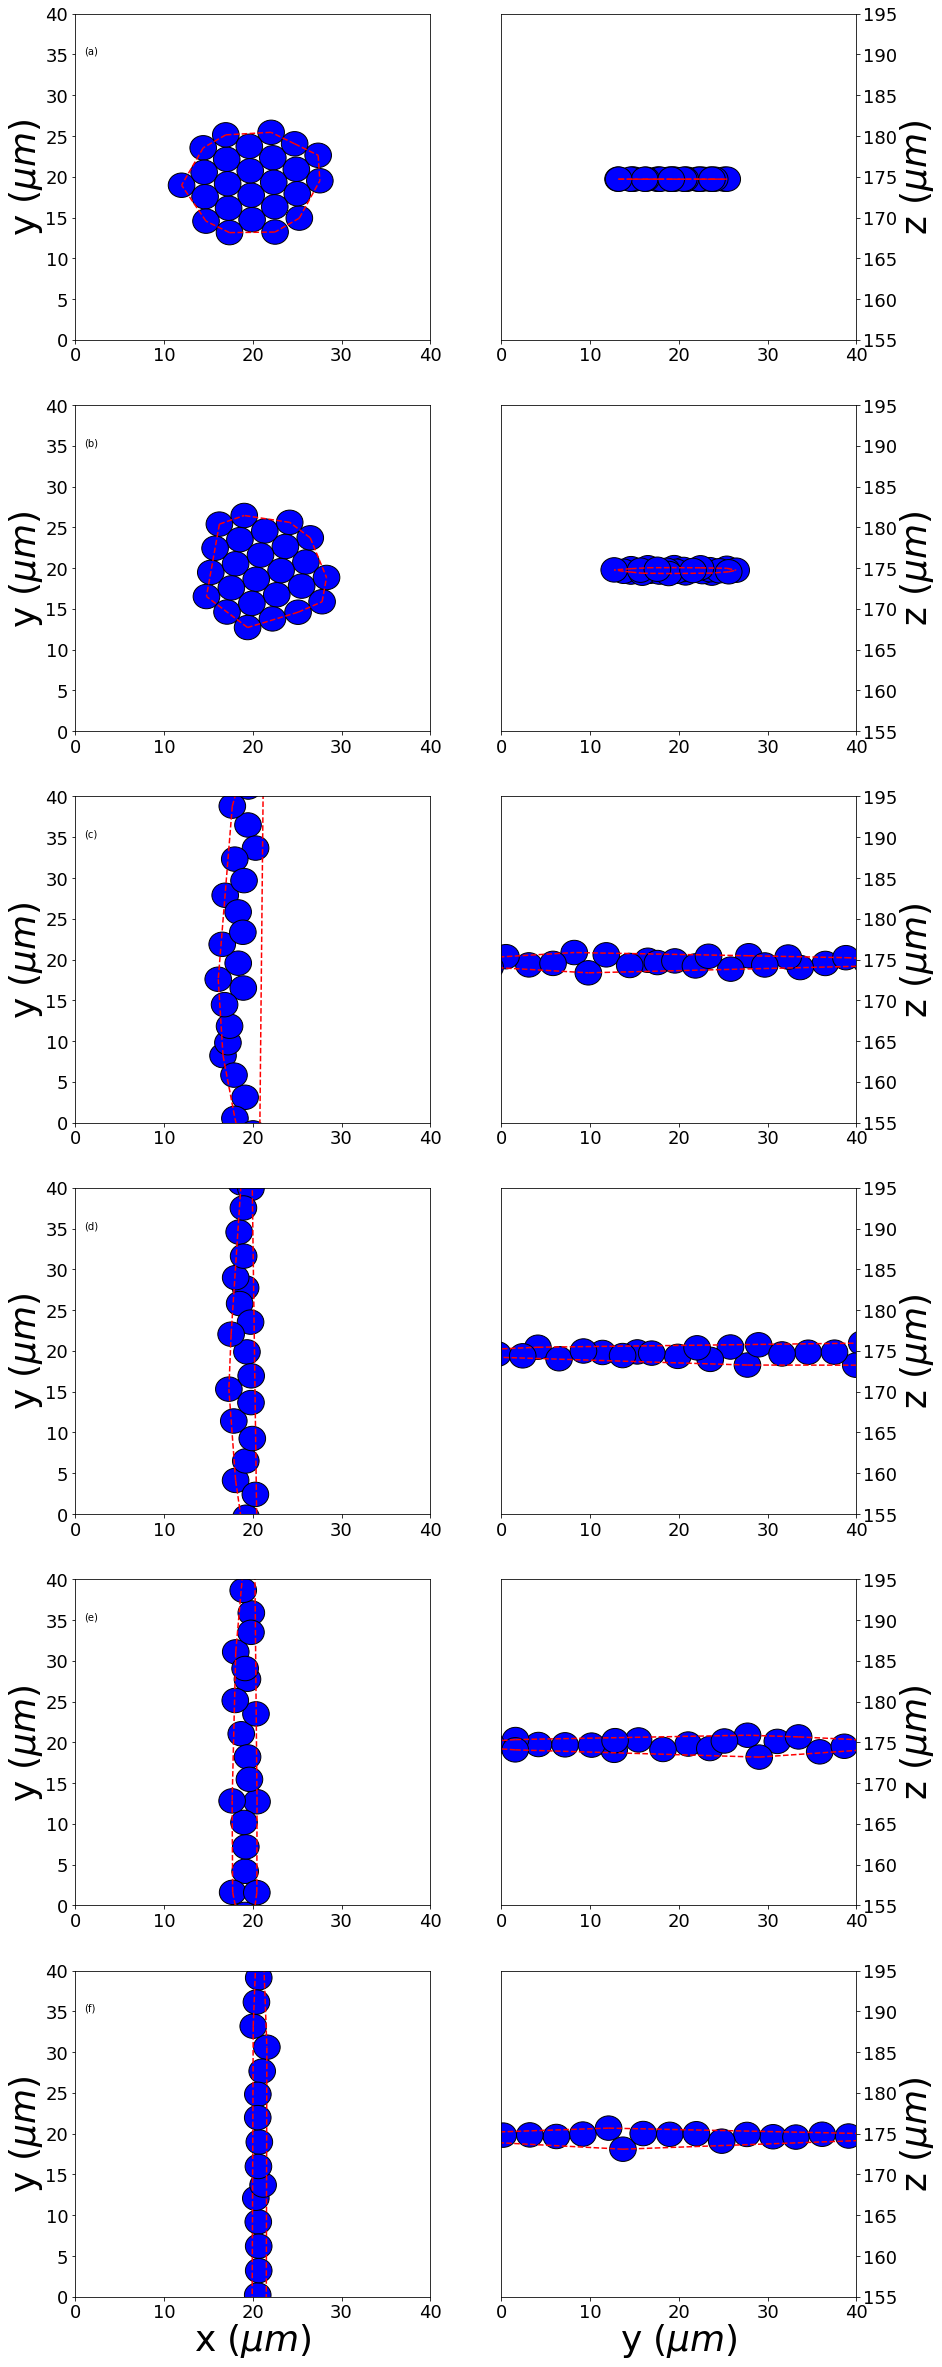

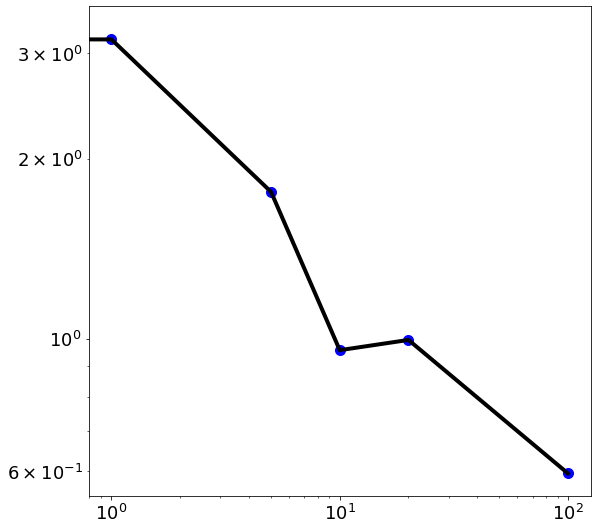

In [134]:
# Load saved data for plotting
dir_name = 'N_25_E0_25_dt_d003_1623088703'
scale = 10**6 

selected_files = ['0','1','5','10','50'] # if set to empty, load everything. Otherwise, only chosen frequencies
selected_files =[]
sorted_list = os.listdir(dir_name)
sorted_list =[x for x in sorted_list if '.npy' in x]
if selected_files != []:
    sorted_list= [x for x in sorted_list if any(('Rotation'+selection+'Hz') in x for selection in selected_files)] # python spaghetti to only keep selected files 
sorted_list = [file.replace('Rotation','') for file in sorted_list] # sort files by rotation rate
sorted_list = [file.replace('Hz.npy','') for file in sorted_list]
sorted_list = [int(x) for x in sorted_list]
sorted_list.sort()
num_files = len(sorted_list)
print(sorted_list)


fig_all, axes = plt.subplots(ncols=2, nrows = num_files, figsize=(7*2,7*num_files))
axes[-1,0].set_xlabel(r'x $(\mu m)$')
axes[-1,1].set_xlabel(r'y $(\mu m)$')
sample = np.load('{}/Rotation0Hz.npy'.format(dir_name))*scale
time_steps = np.shape(sample[:,0,0])[0]
area_arr_xy = np.zeros((num_files,time_steps))
volume_arr_xy = np.zeros((num_files,time_steps))
area_arr_yz = np.zeros((num_files,time_steps))
volume_arr_yz = np.zeros((num_files,time_steps))

for count,file in enumerate(sorted_list):
    positions = np.load('{dir}/Rotation{file}Hz.npy'.format(dir=dir_name,file=file))*scale
    num_particles = np.shape(positions)[1]
    axes[count,0].set_xlim(x_range)
    axes[count,0].set_ylim(y_range)
    axes[count,1].set_xlim(y_range)
    axes[count,1].set_ylim([175-20,175+20])
    axes[count,0].set_ylabel(r'y $(\mu m)$')
    axes[count,1].set_ylabel(r'z $(\mu m)$')
#     axes[count,0].set_title('Rotation Rate: '+ str(file) +' Hz' )
    axes[count,0].text(1,35,'('+ascii_lowercase[count]+')')
    axes[count,1].yaxis.set_label_position("right")
    axes[count,1].yaxis.tick_right()
    for i in range(num_particles):
#         circle_start = plt.Circle((positions[0,i,0], positions[0,i,1]), radius, color='black', ec='black')
#         axes.add_artist(circle_start)
        circle_xy = plt.Circle((positions[-1,i,0], positions[-1,i,1]), radius, color='blue', ec='black')
        circle_yz = plt.Circle((positions[-1,i,1], positions[-1,i,2]), radius, color='blue', ec='black')
        axes[count,0].add_artist(circle_xy)
        axes[count,1].add_artist(circle_yz)
    # Calculate the convex hull to quantify the extent of chaining, show image at final time but plot for all times
    

    for i in range(100,time_steps):
        points_xy = positions[i,:,0:2]
        points_yz = positions[i,:,1:3]
        hull_xy = ConvexHull(points_xy)
        hull_yz = ConvexHull(points_yz)
        area_arr_xy[count,i] = hull_xy.area
        volume_arr_xy[count,i] = hull_xy.volume
        area_arr_yz[count,i] = hull_yz.area
        volume_arr_yz[count,i] = hull_yz.volume
#     print('Perimeter: {} Area: {}, A/P: {}'.format(perimeter,area,area/perimeter))
#     axes[count,2].plot(volume_arr_xy[count,:]/area_arr_xy[count,:], label= 'xy projection')
#     axes[count,2].plot(volume_arr_yz[count,:]/area_arr_yz[count,:], label='yz projection')
#     axes[count,2].legend()
#     axes[count,2].set_ylabel('Area / perimeter (micron)')
#     axes[count,2].set_xlabel('Time step')
#     axes[count,2].set_ylim([0,2])
    for simplex in hull_xy.simplices:
        axes[count,0].plot(points_xy[simplex,0], points_xy[simplex,1],'r--')
    for simplex in hull_yz.simplices:
        axes[count,1].plot(points_yz[simplex,0], points_yz[simplex,1],'r--')


# # Plot the area/perimeter value at the end of each run as a function of rotation rate
# fig_summary, a = plt.subplots(figsize=(9,9))
# line_width =3
# a.plot(sorted_list, volume_arr_xy[:,-1]/area_arr_xy[:,-1], label= 'xy projection', lw= line_width,color='blue')
# a.plot(sorted_list, volume_arr_yz[:,-1]/area_arr_yz[:,-1], label='yz projection', lw = line_width,color='red')
# a.set_ylabel(r'Area/perimeter $(\mu m)$')
# a.set_xlabel('Rotation Rate (Hz)')

## Save figures
# if os.path.isdir('{}/figures/'.format(dir_name)) == 0:
#     os.mkdir('{}/figures'.format(dir_name))
# savefig(fig_all,'{}/figures/simulation_images'.format(dir_name))
# if selected_files ==[]: # only overwrite the summary if the file selection isn't being limited
#     savefig(fig_summary, '{}/figures/apratio_vs_rotationrate'.format(dir_name))

# Save a/p ratio data
np.save('frequencies',sorted_list)
np.save('volume_arr_xy',volume_arr_xy)
np.save('volume_arr_yz',volume_arr_yz)
np.save('area_arr_xy',area_arr_xy)
np.save('area_arr_yz',area_arr_yz)
# Try logarithmic scales for a/p vs rotation rate plots
fig_log, a = plt.subplots(figsize=(9,9))
a.loglog(sorted_list, volume_arr_xy[:,-1]/area_arr_xy[:,-1],'.', label= 'xy projection', lw= line_width,color='blue',ms=20)
a.loglog(sorted_list, volume_arr_xy[:,-1]/area_arr_xy[:,-1],'-', label= 'xy projection', lw= line_width,color='black')
log_x = np.log10(sorted_list)
log_y = np.log10(volume_arr_xy[:,-1]/area_arr_xy[:,-1])
poly = np.polyfit(log_x,log_y,1)                                                                                                     
a.set_ylabel(r'Area/perimeter $(\mu m)$')
a.set_xlabel('Rotation Rate (Hz)')
plt.show()
plt.plot(log_x,log_y,'r')  


[0, 1, 5, 10, 20, 100]
Anim time 68.91176223754883
Anim time 68.7876148223877
Anim time 69.426020860672
Anim time 69.1697371006012
Anim time 69.32237839698792
Anim time 69.06192660331726


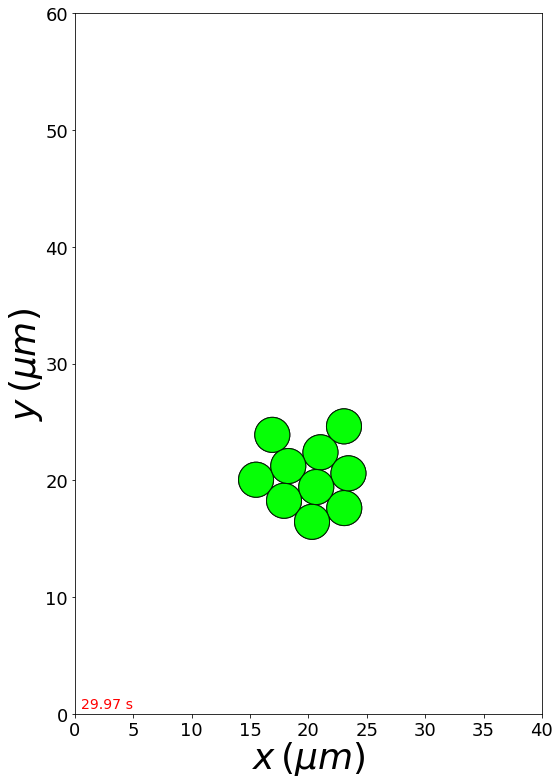

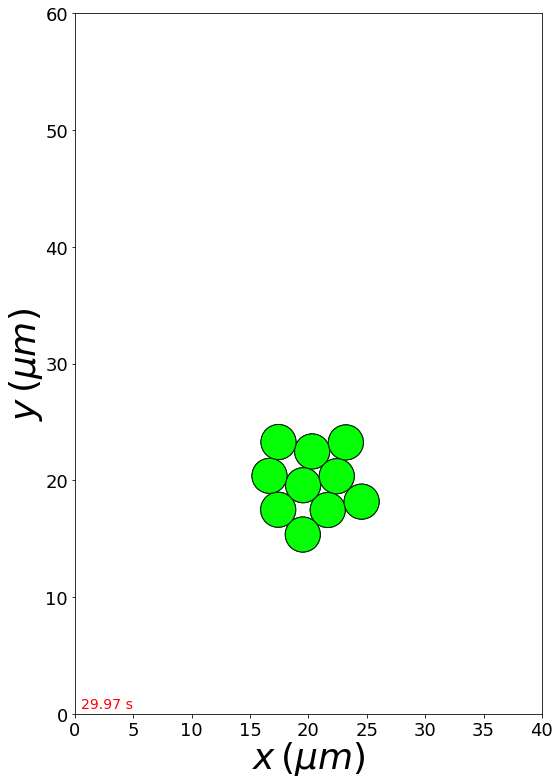

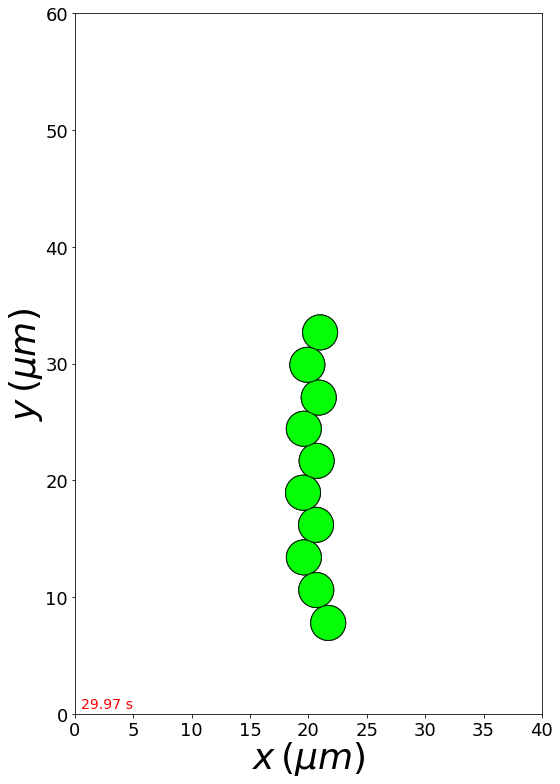

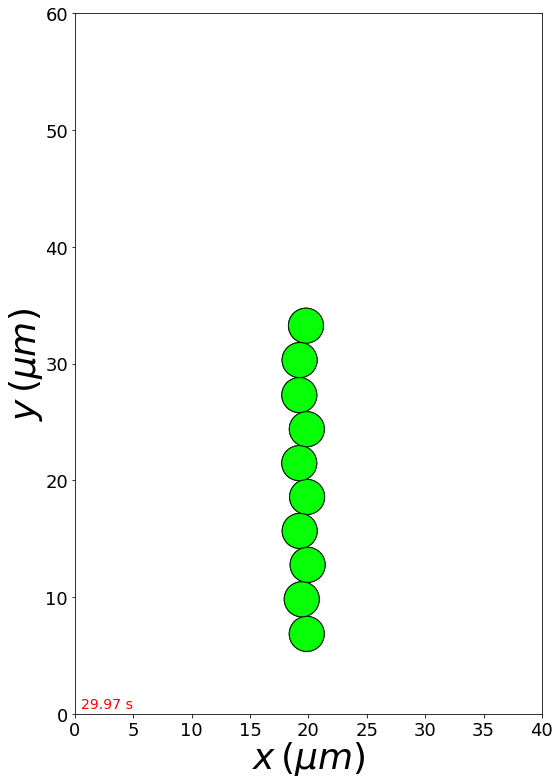

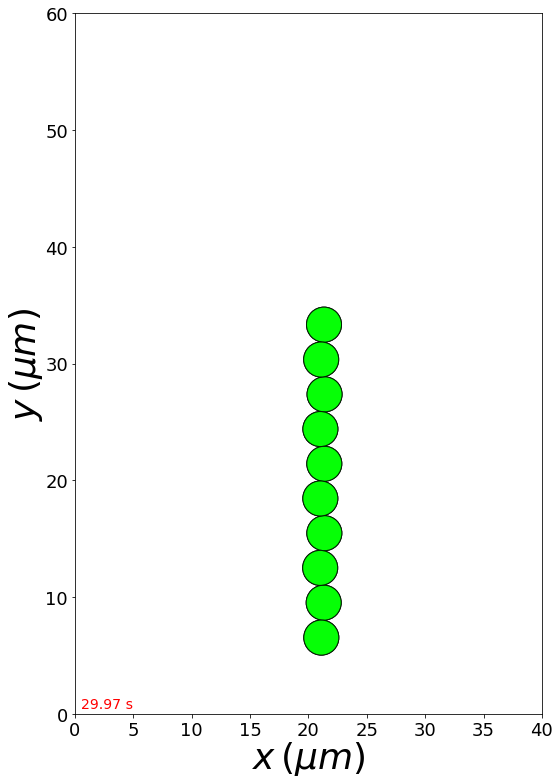

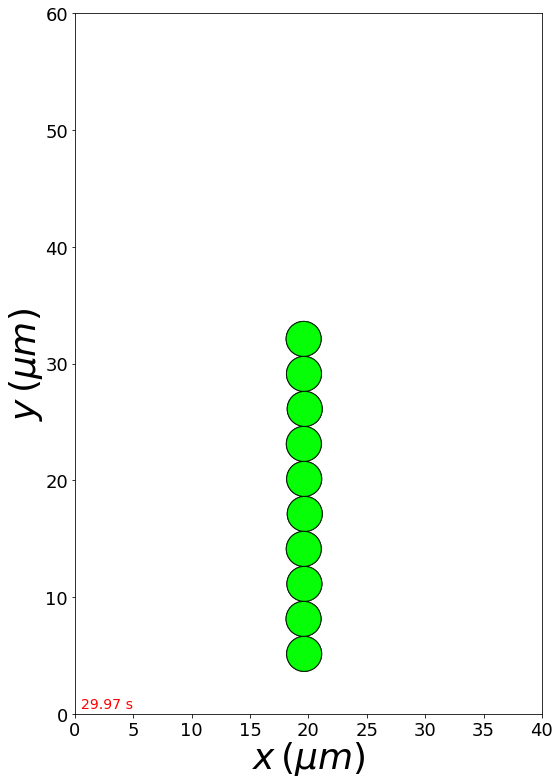

In [170]:

## Generate videos from numpy data 
# Load saved data for plotting
dir_name = 'N_10_E0_20_dt_d003_1623682865'
selected_files = [] # if set to empty, load everything. Otherwise, only chosen frequencies

sorted_list = os.listdir(dir_name)
sorted_list =[x for x in sorted_list if '.npy' in x]
if selected_files != []:
    sorted_list_fullname= [x for x in sorted_list if any(('Rotation'+selection+'Hz') in x for selection in selected_files)] # python spaghetti to only keep selected files 
sorted_list = [file.replace('Rotation','') for file in sorted_list_fullname] # sort files by rotation rate
sorted_list = [file.replace('Hz.npy','') for file in sorted_list]
sorted_list = [int(x) for x in sorted_list]
sorted_list.sort()
num_files = len(sorted_list)
print(sorted_list)

# ind = 2 # select a file to animate and save
for ind in range(len(sorted_list)): # animate and save all in sorted_list
    positions = np.load(dir_name+'/'+'Rotation'+str(sorted_list[ind])+'Hz.npy')
    num_particles = len(positions[0,:,0])
    circle_dict = {}
    x_range = np.asarray([0,resonator_width*.002]) 
    y_range = np.asarray([0,resonator_width*.002]) + np.asarray([-resonator_width*.004,resonator_width*.001])
    z_range = [0,resonator_height]
    x_size = x_range[1]-x_range[0]
    y_size = y_range[1]-y_range[0]
    z_size = z_range[1]-z_range[0]
    size=128
    x_center = (x_range[0]+x_range[1])/2
    y_center = (y_range[0]+y_range[1])/2
    center_pos = [0,0]
    x_pos = positions[:,:,0]
    y_pos = positions[:,:,1]
    z_pos = positions[:,:,2]
    z_center = (z_range[1]-z_range[0])/2
    # alphas = np.exp(-(z_pos-z_center)**2/10)
    alphas = np.ones((total_steps,num_particles))*.7 # place holder
    # Scale positions to microns for plotting
    scale = 10**6
    x_pos *= scale
    y_pos *= scale
    z_pos *= scale
    radius = radius_unscaled*scale
    
    x_range[1] *= scale
    y_range[1] *= scale
    z_range[1] *= scale
    z_center *= scale
    fig, ax = plt.subplots(figsize = (11,11))
    ax.set(adjustable='box', aspect='equal')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel(r'$x\, (\mu m)$')
    ax.set_ylabel(r'$y\, (\mu m)$')
    plt.tight_layout()
    for n in range(num_particles):
        circle_dict["circle"+str(n)] = plt.Circle((x_pos[0,n],y_pos[0,n]),radius,fc='lime',ec='k', alpha=alphas[0,n])



    def init():
        for n in range(num_particles):
            circle_dict["circle"+str(n)].center = (x_pos[0,n],y_pos[0,n])
            circle_dict["circle"+str(n)].set_alpha(alphas[0,n])
            ax.add_patch(circle_dict["circle"+str(n)])
    #         plt.contourf(x_points,y_points, energy_dist)
        return circle_dict.values()
    time_text = ax.text(.5,.5,'',fontsize=14, color='red')
    def animate(i):
        for n in range(num_particles):
            circle_dict["circle"+str(n)].center = (x_pos[i,n],y_pos[i,n])
            circle_dict["circle"+str(n)].set_alpha(alphas[i,n])
            time_text.set_text(str(round(i*time_step,2))+' s')
        return list(circle_dict.values())

    anim_step=10
    frame_time = time_step*anim_step
    num_steps = len(positions[:,0,0])
    frame_list = np.arange(0,num_steps,anim_step)
    time_fac = 1000/1 # 1000: real time
    anim_time = time()
    anim=animation.FuncAnimation(fig,animate,init_func=init,frames=frame_list,interval = frame_time*time_fac ,blit=True)
    anim.save(dir_name+'/'+'Rotation'+str(sorted_list[ind])+'Hz.mp4')
    play=HTML(anim.to_html5_video())
    print('Anim time ' + str(time()-anim_time))
    play

In [165]:
sorted_list = os.listdir(dir_name)
sorted_list =[x for x in sorted_list if '.npy' in x]
sorted_list_fullname = sorted_list
if selected_files != []:
    sorted_list_fullname= [x for x in sorted_list if any(('Rotation'+selection+'Hz') in x for selection in selected_files)] # python spaghetti to only keep selected files 
sorted_list = [file.replace('Rotation','') for file in sorted_list_fullname] # sort files by rotation rate
# sorted_list = [file.replace('Hz.npy','') for file in sorted_list]
# sorted_list = [int(x) for x in sorted_list]
# sorted_list.sort()
# num_files = len(sorted_list)
print(sorted_list)


['1Hz.npy', '0Hz.npy', '10Hz.npy', '5Hz.npy', '20Hz.npy', '100Hz.npy']


Text(0, 0.5, 'Height (microns)')

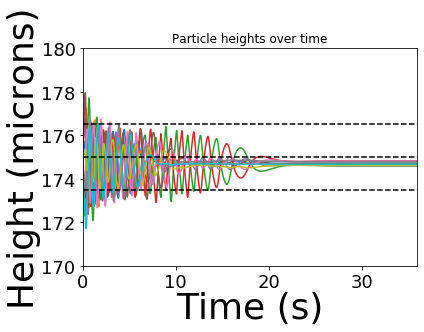

In [122]:
for n in range(num_particles):
    plt.plot(np.array(times), z_pos[:,n])
plt.plot(z_pos[:,n]*0 + z_range[1],'k')
plt.plot(z_pos[:,n]*0 + z_range[0],'k')
plt.plot(z_pos[:,n]*0 + z_center, 'k--')
plt.plot(z_pos[:,n]*0 + z_center+radius, 'k--')
plt.plot(z_pos[:,n]*0 + z_center-radius, 'k--')
plt.ylim([170,180])
plt.xlim([0,time_step*total_steps])
plt.title('Particle heights over time')
plt.xlabel('Time (s)')
plt.ylabel('Height (microns)')

In [4]:
# Notes: an imposed vortex + standing wave seem to be enough to get particles to line up even without
# acoustic interactions. Check this more and compare for different cases.
# Rewrite integration steps to conserve energy (currently, a vortex with no other forces has particles slowly spiral outwards)

In [159]:
#anim.save('videos/E0_100_Spheres_50Hz_TwoChains.mp4')

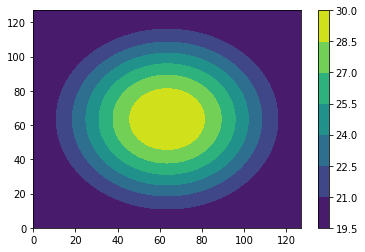

In [345]:
# Troubleshoot long computing time of energy gradient calculation/interpolation
# Troubleshoot gradient force being negligible (might be accurate if this just controls broader aggregation
# regions

In [123]:
# Take functions here for timing/editing/testing

def rotating_spheres(particle_pos):
    # Refined flow field that accounts for the physical size of the spheres
    # There's a 0-order solution which has theta dependence and includes particle size, unlike the rotlet
    # Then a 1st order which includes flows in theta and r directions
    total_flow = np.zeros((num_particles,3))
    a = radius
    Omega = rotation_rate
    rotation_axis = np.array([0,1,0])
    x_hat = np.array([1,0,0])
    y_hat = np.array([0,1,0])
    z_hat = np.array([0,0,1])
    for i in range(num_particles):
        for j in range(num_particles):
            if i!=j:
                r_vec = particle_pos[j,:] - particle_pos[i,:]
                x,y,z = r_vec
                r = np.sqrt(x**2+y**2+z**2)
#                 phi_hat = np.cross(rotation_axis,r_vec)/r #very slow compared to calculating as below, note coord system (z->y)
                phi_hat = (-x*z_hat+z*x_hat)/np.sqrt(x**2+y**2)
                theta = np.arctan2(np.sqrt(z**2+x**2),y)
                total_flow[j,:] += a**3 * Omega * np.sin(theta)/r**2 *phi_hat
                
                if rotation_order == 1:
                    r_hat = r_vec/r
#                     theta_hat = np.cross(phi_hat, r_hat) #Again, much slower, but careful with coordinates
                    theta_hat = ((z*z_hat+x*y_hat)*y-(z**2+x**2)*y_hat)/(r*np.sqrt(z**2+x**2))
                    t1 = (-a**5*Omega**2/8 - a**7*Omega**2/(8*r**2)+a**6*Omega**2/r)
                    if theta==0: #manually remove singularity
                        u_r= -a**5*(a**2-8*a*r+r**2)*Omega**2/(4*r**4)
                    if theta !=0: 
                        u_r = ((np.sin(theta)**-1)*(2*t1*np.cos(theta)**2*np.sin(theta)-t1*np.sin(theta)**3))/(r**2)
                    u_theta = (a**7*Omega**2/(4*r**3)-a**6*Omega**2/r**2)*np.cos(theta)*np.sin(theta)/r
                    total_flow[j,:] += u_r*r_hat + u_theta*theta_hat
    return total_flow

particle_pos = initialize_random(x_range,y_range,z_range,spread=.9)
%lprun -f rotating_spheres rotating_spheres(particle_pos)

In [124]:
timestep=4*10**-3
particle_pos = initialize_random(x_range,y_range,z_range,spread=.9)
particle_vel = np.zeros((num_particles,3))

%lprun -f update_pos  update_pos(particle_pos,particle_vel,timestep)

In [125]:
sorted_list = os.listdir(dir_name)
sorted_list =[x for x in sorted_list if '.npy' in x]
sorted_list = [x for x in sorted_list if any in selected_files in x]
sorted_list

[]

In [56]:
test = 'asqegegfabcaqwrqegf'
[test for checks in ['abc','zzz'] if( checks in  test)]

['asqegegfabcaqwrqegf']

In [69]:
selected_files = ['0','1','5','10','50'] # if set to empty, load everything. Otherwise, only chosen frequencies
sorted_list = os.listdir(dir_name)
sorted_list =[x for x in sorted_list if '.npy' in x]
sorted_list= [x for x in sorted_list if any(('Rotation'+selection+'Hz') in x for selection in selected_files)] # python spaghetti to only keep selected files 


['Rotation50Hz.npy',
 'Rotation1Hz.npy',
 'Rotation0Hz.npy',
 'Rotation10Hz.npy',
 'Rotation5Hz.npy']

ValueError: x and y must have same first dimension, but have shapes (0,) and (6,)

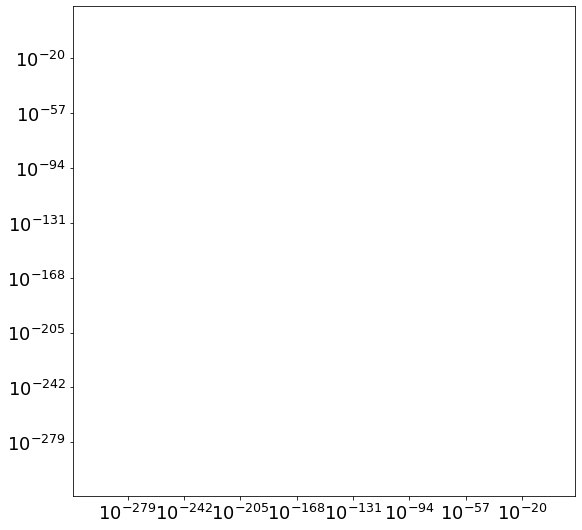

In [127]:
# Try logarithmic scales for a/p vs rotation rate plots
line_width=4
fig_log, a = plt.subplots(figsize=(9,9))
a.loglog(sorted_list, volume_arr_xy[:,-1]/area_arr_xy[:,-1],'.', label= 'xy projection', lw= line_width,color='blue',ms=20)
a.loglog(sorted_list, volume_arr_xy[:,-1]/area_arr_xy[:,-1],'-', label= 'xy projection', lw= line_width,color='black')
log_x = np.log10(sorted_list[1:])
log_y = np.log10(volume_arr_xy[1:,-1]/area_arr_xy[1:,-1])
coefficients = np.polyfit(log_x,log_y,1) 
polynomial = np.poly1d(coefficients)
ys = polynomial(log_x)
a.set_ylabel(r'Area/perimeter $(\mu m)$')
a.set_xlabel('Rotation Rate (Hz)')
a.loglog(sorted_list[1:],10**(ys),'r')
plt.show()
plt.plot(log_x,log_y,'r')  
plt.plot(log_x,ys)

coefficients

array([0.        , 0.30103   , 0.47712125, 0.60205999, 0.69897   ,
       1.        , 1.17609126, 1.30103   , 1.47712125, 1.69897   ,
       2.        ])

In [77]:
sorted_list_fullname

['Rotation3Hz.npy', 'Rotation0Hz.npy', 'Rotation20Hz.npy']

In [81]:
positions = np.load(dir_name+'/'+sorted_list_fullname[0])
positions

array([[[1.67457205e-05, 1.65558405e-05, 1.75000000e-04],
        [2.38186901e-05, 2.06217387e-05, 1.75000000e-04],
        [1.66424959e-05, 1.99195970e-05, 1.75000000e-04],
        ...,
        [2.19459151e-05, 2.28534405e-05, 1.75000000e-04],
        [2.22989464e-05, 2.33170303e-05, 1.75000000e-04],
        [2.18362555e-05, 2.07198876e-05, 1.75000000e-04]],

       [[1.62061312e-05, 1.57818843e-05, 1.75000000e-04],
        [2.49931719e-05, 2.06119775e-05, 1.75000000e-04],
        [1.61626518e-05, 2.13378275e-05, 1.75000000e-04],
        ...,
        [2.03913195e-05, 2.31729211e-05, 1.75000000e-04],
        [2.32194461e-05, 2.42878557e-05, 1.75000000e-04],
        [2.19939507e-05, 2.06380792e-05, 1.75000000e-04]],

       [[1.62068999e-05, 1.57825077e-05, 1.74996039e-04],
        [2.49924527e-05, 2.06118524e-05, 1.74967746e-04],
        [1.61632370e-05, 2.13373066e-05, 1.74994586e-04],
        ...,
        [2.03915531e-05, 2.31723763e-05, 1.74983899e-04],
        [2.32190784e-05, 2.42

In [10]:
dir_name+'/'+sorted_list_fullname[2]

'N_10_E0_25_dt_d006/Rotation20Hz.npy'

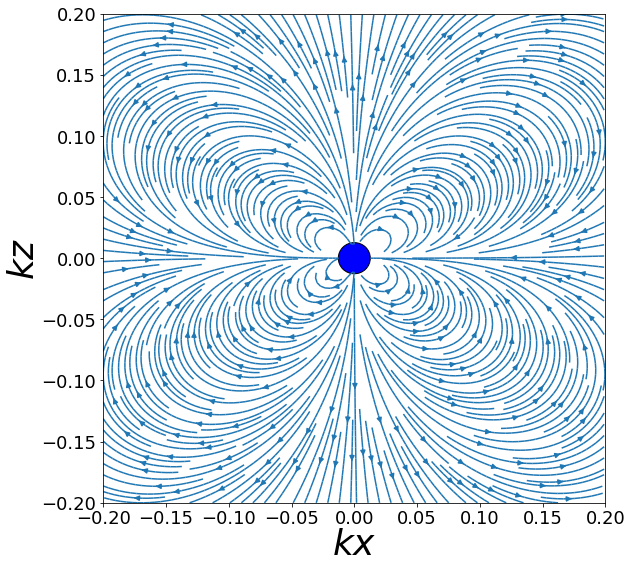

In [106]:
## Plot Bjerknes forces in xz plane due to one sphere trapped at origin
pos_sc = np.asarray([0,0,0])
bound = 0.2
xList = np.linspace(-bound,bound)
zList = np.linspace(-bound,bound)
total_force = np.zeros((len(xList),len(yList),2))
for i in range(len(xList)):
    for j in range(len(zList)):
        xx = xList[i]
        zz = zList[j]
        pos_pr = np.asarray([xx/wavenumber,0,zz/wavenumber])
        total_force[j,i,0]=bjerknes_single(pos_sc,pos_pr)[0]
        total_force[j,i,1]=bjerknes_single(pos_sc,pos_pr)[2]
fig, ax =plt.subplots(figsize=(9,9))
ax.streamplot(xList,zList, total_force[:,:,0],total_force[:,:,1],density=3)
ax.set_xlim([-bound,bound])
ax.set_ylim([-bound,bound])
ax.set_xlabel(r'$kx$')
ax.set_ylabel(r'$kz$')
circle = plt.Circle((0,0), radius_unscaled*2*np.pi/wavelength, color='blue', ec='black')
ax.add_artist(circle)

In [41]:
# troubleshoot nonzero z force when calculating for two particles at z=0
a_p = radius
a_s = radius
E0 = 10
k = wavenumber
R =  1
H = 0
theta = np.pi/2
st = np.sin(theta)
ct = np.cos(theta)
ch = np.cos(H)
sh = np.sin(H)
sr = np.sin(R)
cr = np.cos(R)
chrct = np.cos(H-R*ct)
shrct = np.sin(H-R*ct)

(np.pi*a_p**3*a_s**3*E0*k**4)/(18*R**4)\
                    *(3*R*st*(sr*chrct*(4*f1s*ct*ch*(f0p*R**2+9*f1p)+f0s*f1p*R*sh)+R*shrct*(f1s*ch*(sr*(9*f1p*np.cos(2*theta)-4*f0p)+3*f1p)\
                                                                                            +f0s*f1p*R*ct*sh*sr))\
    +cr*(2*chrct*(2*f0s*R*st*sh*(2*f0p*R**2+3*f1p)+3*f1s*np.sin(2*theta)*ch*(R**2*(f0p-3*f1p)+9*f1p))\
    +3*R*st*shrct*(4*f0s*f1p*R*ct*sh-f1s*ch*(4*f0p*3*f1p*(R**2-3)*np.cos(2*theta)+3*f1p*(R**2-1)))))

19.027249831483

In [117]:
int(time())

1622748933

[0, 1, 2, 3]